In [45]:
import fastf1 as ff1
import fastf1.plotting
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import re
from PIL import Image
import pandas as pd

In [3]:
ff1.Cache.enable_cache('../cache')
fastf1.plotting.setup_mpl()

In [92]:
year, event, event_type = 2023, 'miami', 'FP2'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps(with_telemetry=True)

events        ERROR 	Failed to access primary schedule backend. Falling back to Ergast! Reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Miami Grand Prix - Practice 2 [v2.3.1]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\getou\AppDat

In [104]:
driver_1, driver_2, driver_3, driver_4 = 'VER', 'SAI', 'ALO', 'NOR'

In [105]:
def adjust_color_shade(color, shade_factor):
    color_rgb = mcolors.hex2color(color)
    return mcolors.to_hex([c * shade_factor for c in color_rgb])

laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)
laps_driver_3 = laps.pick_driver(driver_3)
laps_driver_4 = laps.pick_driver(driver_4)

fastest_driver_1 = laps_driver_1.pick_fastest().get_telemetry().add_distance()
fastest_driver_2 = laps_driver_2.pick_fastest().get_telemetry().add_distance()
fastest_driver_3 = laps_driver_3.pick_fastest().get_telemetry().add_distance()
fastest_driver_4 = laps_driver_4.pick_fastest().get_telemetry().add_distance()

fastest_driver_1['Driver'] = driver_1
fastest_driver_2['Driver'] = driver_2
fastest_driver_3['Driver'] = driver_3
fastest_driver_4['Driver'] = driver_4

team_1 = laps_driver_1.pick_fastest()
team_2 = laps_driver_2.pick_fastest()
team_3 = laps_driver_3.pick_fastest()
team_4 = laps_driver_4.pick_fastest()

team_color_1 = ff1.plotting.team_color(str(team_1['Team']))
team_color_2 = ff1.plotting.team_color(str(team_2['Team']))
team_color_3 = ff1.plotting.team_color(str(team_3['Team']))
team_color_4 = ff1.plotting.team_color(str(team_4['Team']))

color_shade_factor = 0.6
visualized_teams = []
team_colors = {}

for driver in [driver_1, driver_2, driver_3, driver_4]:
    team = pd.unique(laps.loc[laps['Driver'] == driver, 'Team'])[0]

    if team not in visualized_teams:
        team_colors[driver] = ff1.plotting.team_color(team)
        visualized_teams.append(team)
    else:
        team_colors[driver] = adjust_color_shade(ff1.plotting.team_color(team), color_shade_factor)



#team_colors = [team_color_1, team_color_2, team_color_3]
team_colors = [team_colors[driver_1], team_colors[driver_2], team_colors[driver_3], team_colors[driver_4]]
telemetry = fastest_driver_1.append(fastest_driver_2).append(fastest_driver_3).append(fastest_driver_4)

C:\Users\getou\AppData\Local\Temp\ipykernel_28468\1270437158.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_driver_1.append(fastest_driver_2).append(fastest_driver_3).append(fastest_driver_4)
C:\Users\getou\AppData\Local\Temp\ipykernel_28468\1270437158.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_driver_1.append(fastest_driver_2).append(fastest_driver_3).append(fastest_driver_4)
C:\Users\getou\AppData\Local\Temp\ipykernel_28468\1270437158.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_driver_1.append(fastest_driver_2).append(fastest_driver_3).append(fastest_driver_4)


In [106]:
num_minisectors = 25
total_distance = total_distance = max(telemetry['Distance'])
minisector_length = total_distance / num_minisectors

In [107]:
minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [108]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [109]:
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [110]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [111]:
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])
telemetry = telemetry.sort_values(by=['Distance'])
telemetry.loc[telemetry['Fastest_driver'] == driver_1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver_2, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver_3, 'Fastest_driver_int'] = 3
telemetry.loc[telemetry['Fastest_driver'] == driver_4, 'Fastest_driver_int'] = 4

In [112]:
# Calculate the number of minisectors dominated by each driver
minisectors_dominated_driver_1 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_1, 'Minisector'].unique())
minisectors_dominated_driver_2 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_2, 'Minisector'].unique())
minisectors_dominated_driver_3 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_3, 'Minisector'].unique())
minisectors_dominated_driver_4 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_4, 'Minisector'].unique())

# Calculate the percentage of the track dominated by each driver
track_dominated_percentage_driver_1 = (minisectors_dominated_driver_1 / num_minisectors) * 100
track_dominated_percentage_driver_2 = (minisectors_dominated_driver_2 / num_minisectors) * 100
track_dominated_percentage_driver_3 = (minisectors_dominated_driver_3 / num_minisectors) * 100
track_dominated_percentage_driver_4 = (minisectors_dominated_driver_4 / num_minisectors) * 100

In [113]:
plot_width = 18
plot_height = 10
plot_size = [plot_width, plot_height]
# Calculate font sizes based on the plot size
title_font_size = int(2.15 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
plot_title = f"{session.event.year} {session.event.EventName} {event_type} \n {driver_1} dominated: {track_dominated_percentage_driver_1: .2f}% \n {driver_2} dominated: {track_dominated_percentage_driver_2: .2f}% \n {driver_3} dominated: {track_dominated_percentage_driver_3: .2f}% \n {driver_4} dominated: {track_dominated_percentage_driver_4: .2f}%"
plot_file = f"{session.event.year} {session.event.EventName}-{driver_1} VS {driver_2}-TrackDomination"
plot_filename = re.sub(r'\W+', '', plot_file.replace("\n", " ")) + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

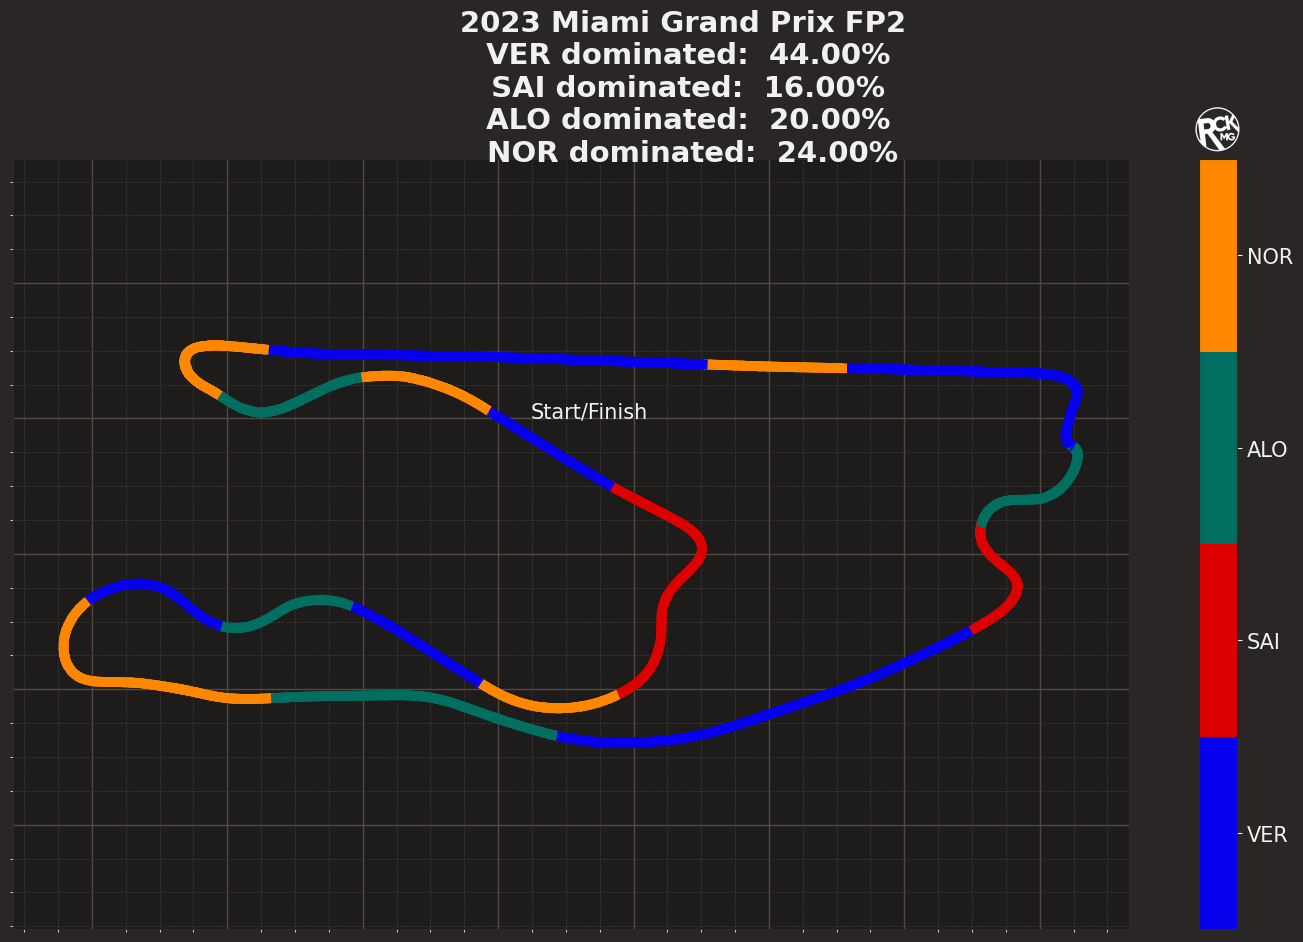

In [114]:
fig, ax = plt.subplots(sharex=True, sharey=True)
ax.set_aspect('equal', 'box')
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

plt.suptitle(plot_title, fontsize=title_font_size, fontweight='bold', y=1.03)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-3], points[3:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Find the y-coordinate of the starting point
start_y = segments[0][0][1]

# Calculate the width of the track
track_width = 7

# Set the start/finish line width to half of the track width
line_width = track_width / 2

# Draw the start/finish line
xmin = segments[0][0][0]
xmax = xmin + line_width
plt.hlines(y=start_y, xmin=xmin, xmax=xmax, color='white', linestyle='--', linewidth=2)

# Add the "Start/Finish" text
text_x = xmax + 600
text_y = start_y
plt.text(text_x, text_y, 'Start/Finish', fontsize=axis_label_font_size, verticalalignment='center')


cmap = mcolors.ListedColormap(team_colors)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap, joinstyle='round')  # Add joinstyle='round'
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(track_width)

plt.rcParams['figure.figsize'] = plot_size

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)


cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,6))
cbar.set_ticks([1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels([driver_1, driver_2, driver_3, driver_4])
cbar.ax.tick_params(labelsize=15)

# Define the new width and height for the logo
new_width = 45
new_height = 45
# Resize the logo
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 1195
logo_y = 790
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

#plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
#print("Unique values in the fastest_driver_array:", np.unique(fastest_driver_array))